In [39]:
import rioxarray as rx
import xarray as xr
import rasterio as rio
import matplotlib.pyplot as plt

import h5py as h5
import dask as da
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [40]:
from glob import glob
from pprint import pprint
import pandas as pd

In [41]:
import json
import os

In [42]:
# substitute any NEON NIS file here
files = glob('../../NEON_spectrometer-orthorectified-surface-directional-reflectance/*.h5')
print(len(files))

sigma=1.201
sigma=(1/2.355)
sigma=2.355/2

104


In [43]:
# read the landsat 8 curves
l8_file = './spectral_response/Ball_BA_RSR.v1.2.xlsx'
l8_rsr_ca = pd.read_excel(l8_file, sheet_name='CoastalAerosol')
l8_rsr_b = pd.read_excel(l8_file, sheet_name='Blue')
l8_rsr_g = pd.read_excel(l8_file, sheet_name='Green')
l8_rsr_r = pd.read_excel(l8_file, sheet_name='Red')
l8_rsr_nir = pd.read_excel(l8_file, sheet_name='NIR')
l8_rsr_swir1 = pd.read_excel(l8_file, sheet_name='SWIR1')
l8_rsr_swir2 = pd.read_excel(l8_file, sheet_name='SWIR2')

In [44]:
l8_rsr_ca

Wavelength  BA RSR [watts]  stdev(RSR)
0          427        0.000073    0.000000
1          428        0.000609    0.000086
2          429        0.001628    0.000143
3          430        0.003421    0.000274
4          431        0.008019    0.000606
5          432        0.024767    0.002033
6          433        0.085688    0.008333
7          434        0.254149    0.022668
8          435        0.517821    0.026035
9          436        0.765117    0.016377
10         437        0.908749    0.010562
11         438        0.958204    0.007447
12         439        0.977393    0.007081
13         440        0.983790    0.005655
14         441        0.989052    0.001909
15         442        0.986713    0.003349
16         443        0.993683    0.003059
17         444        0.993137    0.001720
18         445        1.000000    0.003818
19         446        0.996969    0.006370
20         447        0.982780    0.004858
21         448        0.972692    0.005661
22         449        0.905808    0.017868
23         450        0.745606    0.028282
24         451        0.471329    0.024486
25         452        0.226412    0.012833
26         453        0.092860    0.006431
27         454        0.036603    0.003277
28         455        0.014537    0.001545
29         456        0.005829    0.000679
30         457        0.002414    0.000297
31         458        0.000984    0.000142
32         459        0.000255    0.000083

In [45]:
# make function for reading h5 tiles
def read_h5_file(fi):
    # Read H5 file
    f = h5.File(fi, "r")
    nid = 'CPER'
    # spectral
    wavelength = f[nid]['Reflectance']['Metadata']['Spectral_Data']['Wavelength'][:]
    fwhm = f[nid]['Reflectance']['Metadata']['Spectral_Data']['FWHM'][:]

    # CRS
    crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
    crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'].value
    crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'].value
    crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Proj4'].value

    #arr = f[nid]['Radiance']['Radiance_Data'][:]
    arr = da.array.from_array(f[nid]['Reflectance']['Reflectance_Data'], chunks=(256,256,256))

    mapinfo_list = [a.strip() for a in str(crs_mapinfo).split(',')]
    mapinfo = [float(a) for a in mapinfo_list[1:7]]
    mapinfo
    pix_size = mapinfo[0]
    x = np.arange(mapinfo[2], mapinfo[2] + pix_size*arr.shape[1], pix_size)
    y = np.arange(mapinfo[3], mapinfo[3] - pix_size* arr.shape[0], -pix_size)

    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != -9999)
    
    # add in CRS assignemnt!!!!!!!!!!!!
    
    return xr_cube_ma, f[nid]['Reflectance']['Metadata']

In [46]:
Refl, metadata = read_h5_file(files[1])

In [47]:
metadata.keys(), metadata['Spectral_Data'].keys()

(<KeysViewHDF5 ['Ancillary_Imagery', 'Coordinate_System', 'Flight_Trajectory', 'Logs', 'Spectral_Data', 'to-sensor_azimuth_angle', 'to-sensor_zenith_angle']>,
 <KeysViewHDF5 ['FWHM', 'Wavelength']>)

In [48]:
nis_wavs = metadata['Spectral_Data']['Wavelength'][:]
nis_fwhm = metadata['Spectral_Data']['FWHM'][:]
nis_wavs.shape, nis_fwhm.shape,l8_rsr_ca['Wavelength'].values.shape

((426,), (426,), (33,))

In [49]:
def get_fit_wave(params,num_value,num_peak):

    #

    # this callback calculates f(c,x)=exp(-c0*sqr(x0))

    # where x is a position on X-axis and c is adjustable parameter

    

    

    #num_peak = initial_params[0,-1]

    #num_peak = 1

    c = params[0,0:int(num_peak*3)]

       

    x = np.arange(1,num_value)

   

    if num_peak ==1:

        wave = c[0]*np.exp(-((x-c[1])/c[2])**2)

    elif num_peak == 2:

        wave = c[0]*np.exp(-((x-c[1])/c[2])**2)+c[3]*np.exp(-((x-c[4])/c[5])**2)

    elif num_peak == 3:

        wave = c[0]*np.exp(-((x-c[1])/c[2])**2)+c[3]*np.exp(-((x-c[4])/c[5])**2)+c[6]*np.exp(-((x-c[7])/c[8])**2)

    elif num_peak == 4:

        wave = c[0]*np.exp(-((x-c[1])/c[2])**2)+c[3]*np.exp(-((x-c[4])/c[5])**2)+c[6]*np.exp(-((x-c[7])/c[8])**2)+c[9]*np.exp(-((x-c[10])/c[11])**2) 

    elif num_peak == 5:

        wave = c[0]*np.exp(-((x-c[1])/c[2])**2)+c[3]*np.exp(-((x-c[4])/c[5])**2)+c[6]*np.exp(-((x-c[7])/c[8])**2)+c[9]*np.exp(-((x-c[10])/c[11])**2)+c[12]*np.exp(-((x-c[13])/c[14])**2) 

    elif num_peak == 6:

        wave = c[0]*np.exp(-((x-c[1])/c[2])**2)+c[3]*np.exp(-((x-c[4])/c[5])**2)+c[6]*np.exp(-((x-c[7])/c[8])**2)+c[9]*np.exp(-((x-c[10])/c[11])**2)+c[12]*np.exp(-((x-c[13])/c[14])**2)+c[15]*np.exp(-((x-c[16])/c[17])**2) 

    elif num_peak == 7:

        wave = c[0]*np.exp(-((x-c[1])/c[2])**2)+c[3]*np.exp(-((x-c[4])/c[5])**2)+c[6]*np.exp(-((x-c[7])/c[8])**2)+c[9]*np.exp(-((x-c[10])/c[11])**2)+c[12]*np.exp(-((x-c[13])/c[14])**2)+c[15]*np.exp(-((x-c[16])/c[17])**2)+c[18]*np.exp(-((x-c[19])/c[20])**2) 

        

    return wave 

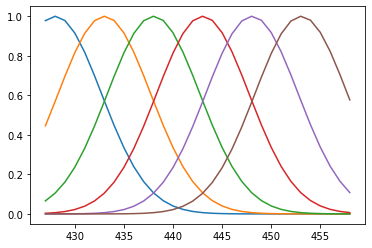

array([ 1.3417733,  4.935999 ,  9.195765 , 10.405921 ,  7.676645 ,
        3.1947198], dtype=float32)

In [50]:
# Tristan's code to resample spectra

HS_band_centers = nis_wavs
HS_FWHM = nis_fwhm

target_bandpass = l8_rsr_ca['Wavelength'].values
target_RSR = l8_rsr_ca['BA RSR [watts]'].values

values_lower = np.where(HS_band_centers>np.min(target_bandpass))
values_upper = np.where(HS_band_centers<np.max(target_bandpass))
values = np.intersect1d(values_lower,values_upper) # valid band centers relative to target band pass

elements = values.shape[0]


target_resample_range = np.arange(np.min(target_bandpass),np.max(target_bandpass),1)
target_resample = np.interp(target_resample_range, target_bandpass, target_RSR)

weights = np.zeros_like(values,dtype=np.float32)

for i in range(elements):

    NEON_guassian_wave_params = np.array([[1,HS_band_centers[values[i]]-target_bandpass[0]-(HS_band_centers[values[0]]-target_bandpass[0])+2,sigma*HS_FWHM[values[i]]]],dtype = np.float32)
    NEON_gaussian_wave = get_fit_wave(NEON_guassian_wave_params, target_bandpass[-1]-target_bandpass[0]+1, 1)
    weights[i] = np.convolve(target_resample,NEON_gaussian_wave,mode='valid')
    plt.plot(target_resample_range,NEON_gaussian_wave)
    
plt.show()
weights

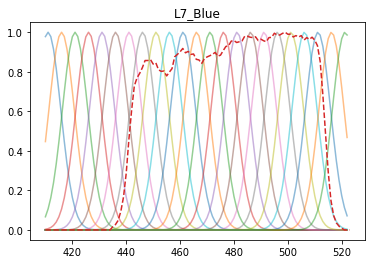

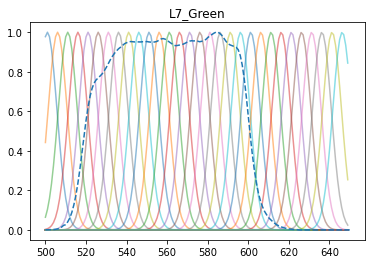

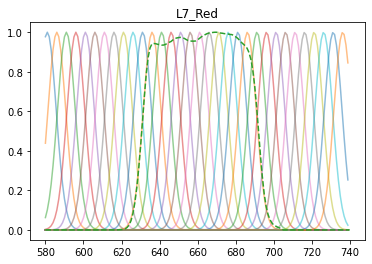

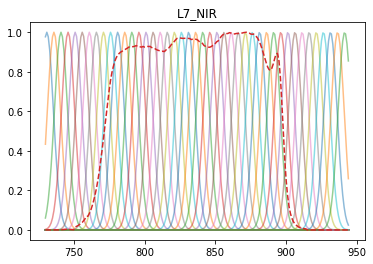

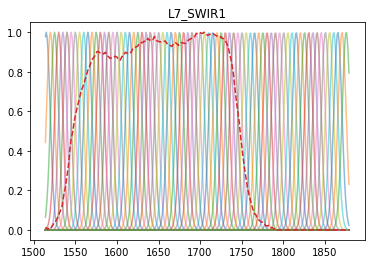

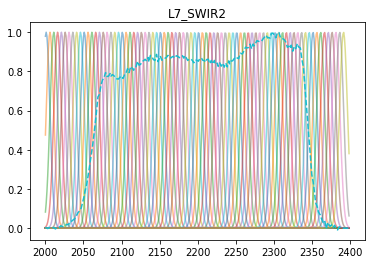

In [51]:
# do this for all landsat bands
# Tristan's code to resample spectra

# read the landsat 7 curves
l7_file = './spectral_response/L7_ETM_RSR.xlsx'
l7_rsr_b = pd.read_excel(l7_file, sheet_name='Blue-L7')
l7_rsr_g = pd.read_excel(l7_file, sheet_name='Green-L7')
l7_rsr_r = pd.read_excel(l7_file, sheet_name='Red-L7')
l7_rsr_nir = pd.read_excel(l7_file, sheet_name='NIR-L7')
l7_rsr_swir1 = pd.read_excel(l7_file, sheet_name='SWIR(5)-L7')
l7_rsr_swir2 = pd.read_excel(l7_file, sheet_name='SWIR(7)-L7')

HS_band_centers = nis_wavs
HS_FWHM = nis_fwhm
iter_bands = zip((l7_rsr_b, l7_rsr_g, l7_rsr_r, l7_rsr_nir, l7_rsr_swir1, l7_rsr_swir2),
                 ('L7_Blue', 'L7_Green', 'L7_Red', 'L7_NIR', 'L7_SWIR1', 'L7_SWIR2'),
                 (1,2,3,4,5,7))

L7_weights_dict = {}
for l7_band, band_label, ctr in iter_bands:
    target_bandpass = l7_band['Wavelength'].values
    target_RSR = l7_band[f'Band {ctr}'].values

    values_lower = np.where(HS_band_centers>np.min(target_bandpass))
    values_upper = np.where(HS_band_centers<np.max(target_bandpass))
    values = np.intersect1d(values_lower,values_upper) # valid band centers relative to target band pass

    elements = values.shape[0]


    target_resample_range = np.arange(np.min(target_bandpass),np.max(target_bandpass),1)
    target_resample = np.interp(target_resample_range, target_bandpass, target_RSR)

    weights = np.zeros_like(values,dtype=np.float32)

    for i in range(elements):

        NEON_guassian_wave_params = np.array([[1,HS_band_centers[values[i]]-target_bandpass[0]-(HS_band_centers[values[0]]-target_bandpass[0])+2,sigma*HS_FWHM[values[i]]]],dtype = np.float32)
        NEON_gaussian_wave = get_fit_wave(NEON_guassian_wave_params, target_bandpass[-1]-target_bandpass[0]+1, 1)
        weights[i] = np.convolve(target_resample,NEON_gaussian_wave,mode='valid')
        plt.plot(target_resample_range,NEON_gaussian_wave, alpha=0.5)

    plt.plot(target_bandpass, target_RSR, '--')
    plt.title(band_label)
    plt.show()
    
    L7_weights_dict[band_label] = (weights.tolist(), values.tolist())

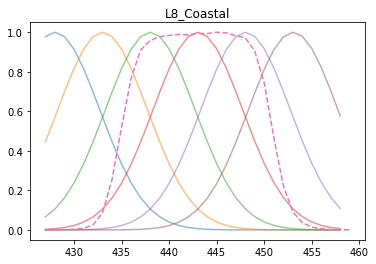

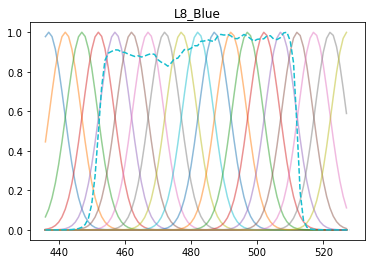

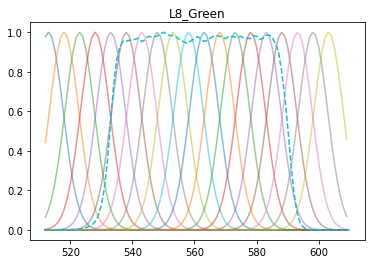

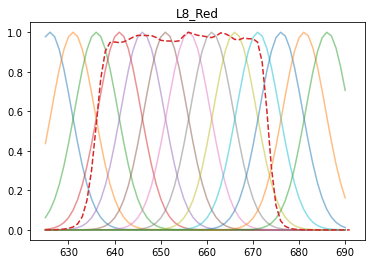

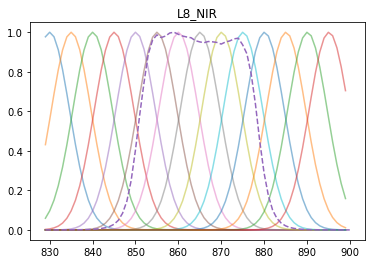

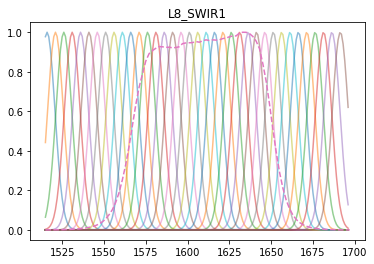

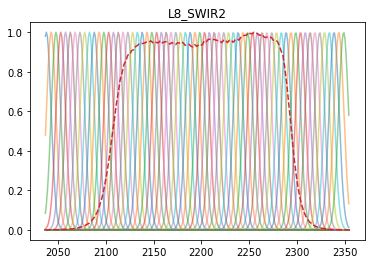

In [52]:
# do this for all landsat 7 bands
# Tristan's code to resample spectra

HS_band_centers = nis_wavs
HS_FWHM = nis_fwhm
iter_bands = zip((l8_rsr_ca, l8_rsr_b, l8_rsr_g, l8_rsr_r, l8_rsr_nir, l8_rsr_swir1, l8_rsr_swir2),
                 ('L8_Coastal', 'L8_Blue', 'L8_Green', 'L8_Red', 'L8_NIR', 'L8_SWIR1', 'L8_SWIR2'))

L8_weights_dict = {}
for l8_band, band_label in iter_bands:
    target_bandpass = l8_band['Wavelength'].values
    target_RSR = l8_band['BA RSR [watts]'].values

    values_lower = np.where(HS_band_centers>np.min(target_bandpass))
    values_upper = np.where(HS_band_centers<np.max(target_bandpass))
    values = np.intersect1d(values_lower,values_upper) # valid band centers relative to target band pass

    elements = values.shape[0]


    target_resample_range = np.arange(np.min(target_bandpass),np.max(target_bandpass),1)
    target_resample = np.interp(target_resample_range, target_bandpass, target_RSR)

    weights = np.zeros_like(values,dtype=np.float32)

    for i in range(elements):

        NEON_guassian_wave_params = np.array([[1,HS_band_centers[values[i]]-target_bandpass[0]-(HS_band_centers[values[0]]-target_bandpass[0])+2,sigma*HS_FWHM[values[i]]]],dtype = np.float32)
        NEON_gaussian_wave = get_fit_wave(NEON_guassian_wave_params, target_bandpass[-1]-target_bandpass[0]+1, 1)
        weights[i] = np.convolve(target_resample,NEON_gaussian_wave,mode='valid')
        plt.plot(target_resample_range,NEON_gaussian_wave, alpha=0.5)

    plt.plot(target_bandpass, target_RSR, '--')
    plt.title(band_label)
    plt.show()
    
    L8_weights_dict[band_label] = (weights.tolist(), values.tolist())

do the same for sentinel-2

In [53]:
s2_file = './spectral_response/S2-SRF_COPE-GSEG-EOPG-TN-15-0007_3.0.xlsx'
s2a_df = pd.read_excel(s2_file, sheet_name='Spectral Responses (S2A)')
s2b_df = pd.read_excel(s2_file, sheet_name='Spectral Responses (S2B)')
s2a_df.head()

SR_WL  S2A_SR_AV_B1  S2A_SR_AV_B2  S2A_SR_AV_B3  S2A_SR_AV_B4  \
0    300           0.0           0.0           0.0           0.0   
1    301           0.0           0.0           0.0           0.0   
2    302           0.0           0.0           0.0           0.0   
3    303           0.0           0.0           0.0           0.0   
4    304           0.0           0.0           0.0           0.0   

   S2A_SR_AV_B5  S2A_SR_AV_B6  S2A_SR_AV_B7  S2A_SR_AV_B8  S2A_SR_AV_B8A  \
0           0.0           0.0           0.0           0.0            0.0   
1           0.0           0.0           0.0           0.0            0.0   
2           0.0           0.0           0.0           0.0            0.0   
3           0.0           0.0           0.0           0.0            0.0   
4           0.0           0.0           0.0           0.0            0.0   

   S2A_SR_AV_B9  S2A_SR_AV_B10  S2A_SR_AV_B11  S2A_SR_AV_B12  
0           0.0            0.0            0.0            0.0  
1           0.0            0.0            0.0            0.0  
2           0.0            0.0            0.0            0.0  
3           0.0            0.0            0.0            0.0  
4           0.0            0.0            0.0            0.0

In [54]:
s2a_band_text = ['S2A_' + c.split('_')[-1] for c in s2a_df.columns[1:]]
s2a_bands = [c for c in s2a_df.columns[1:]]
s2a_wavs = s2a_df['SR_WL'].values

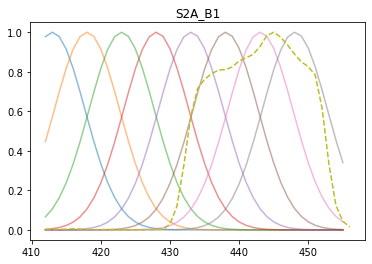

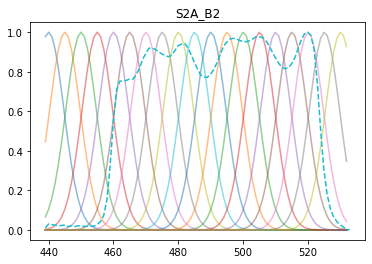

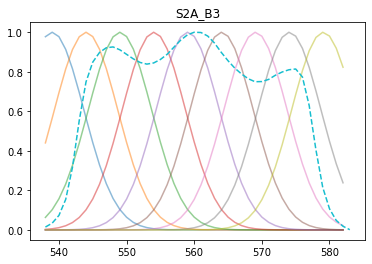

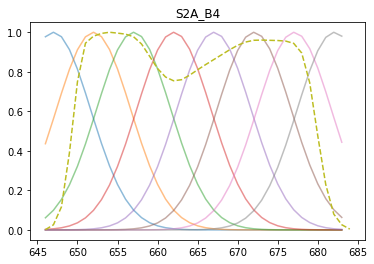

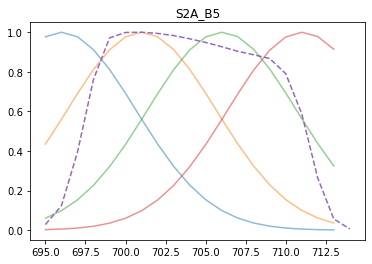

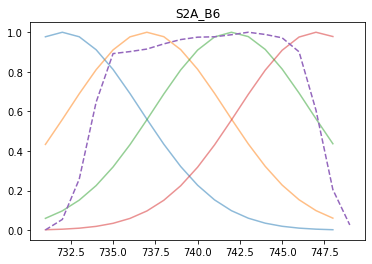

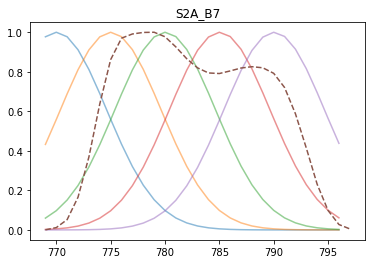

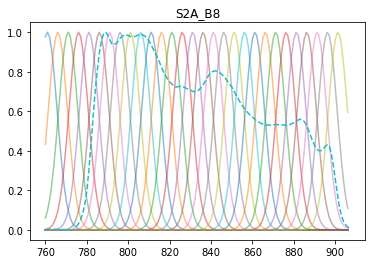

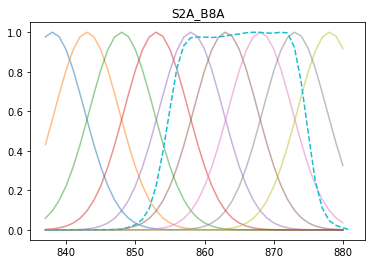

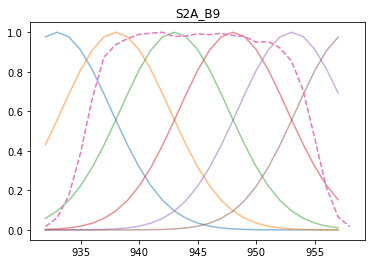

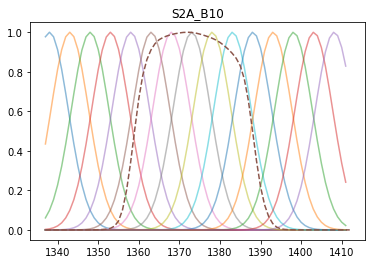

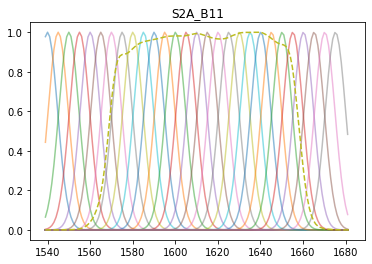

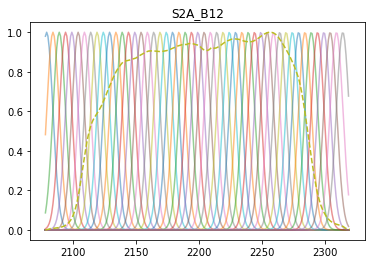

In [55]:
# get the sentinel-2a weights

HS_band_centers = nis_wavs
HS_FWHM = nis_fwhm
iter_bands = zip(s2a_bands, s2a_band_text)

S2A_weights_dict = {}
for s2_band, band_label in iter_bands:
#     target_bandpass = s2a_wavs
#     target_RSR = s2a_df[s2_band].values
    
    target_RSR = s2a_df[s2_band].values
    idx = np.where(target_RSR > 0)
    target_RSR = target_RSR[idx]
    target_bandpass = s2a_wavs[idx]

    values_lower = np.where(HS_band_centers>np.min(target_bandpass))
    values_upper = np.where(HS_band_centers<np.max(target_bandpass))
    values = np.intersect1d(values_lower,values_upper) # valid band centers relative to target band pass

    elements = values.shape[0]


    target_resample_range = np.arange(np.min(target_bandpass),np.max(target_bandpass),1)
    target_resample = np.interp(target_resample_range, target_bandpass, target_RSR)

    weights = np.zeros_like(values,dtype=np.float32)

    for i in range(elements):

        NEON_guassian_wave_params = np.array([[1,HS_band_centers[values[i]]-target_bandpass[0]-(HS_band_centers[values[0]]-target_bandpass[0])+2,sigma*HS_FWHM[values[i]]]],dtype = np.float32)
        NEON_gaussian_wave = get_fit_wave(NEON_guassian_wave_params, target_bandpass[-1]-target_bandpass[0]+1, 1)
        weights[i] = np.convolve(target_resample,NEON_gaussian_wave,mode='valid')
        plt.plot(target_resample_range,NEON_gaussian_wave, alpha=0.5)

    plt.plot(target_bandpass, target_RSR, '--')
    plt.title(band_label)
    plt.show()
    
    S2A_weights_dict[band_label] = (weights.tolist(), values.tolist())

Do the same for Sentinel-2B

In [56]:
s2b_band_text = ['S2B_' + c.split('_')[-1] for c in s2b_df.columns[1:]]
s2b_bands = [c for c in s2b_df.columns[1:]]
s2b_wavs = s2b_df['SR_WL'].values

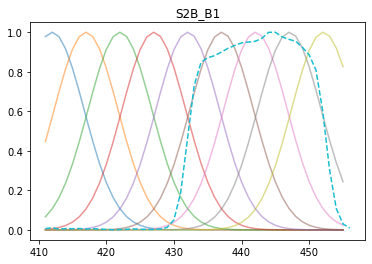

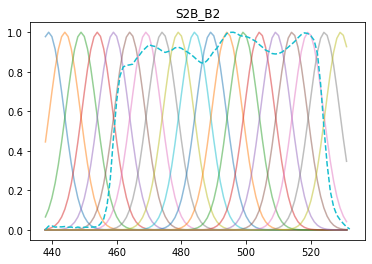

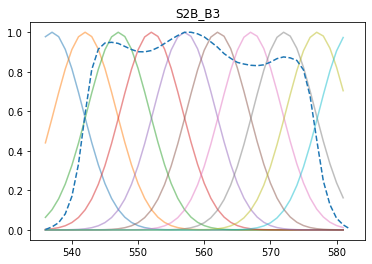

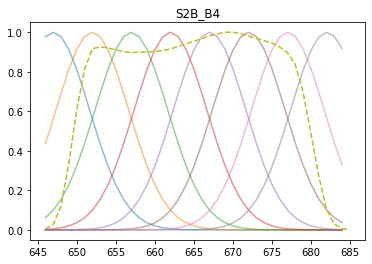

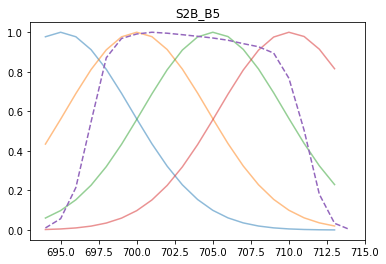

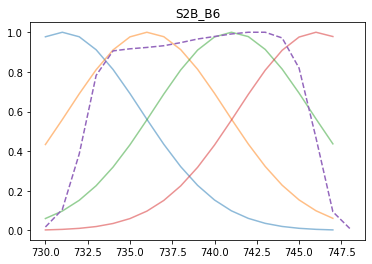

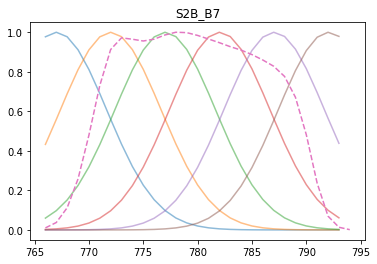

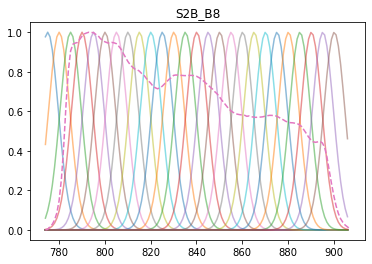

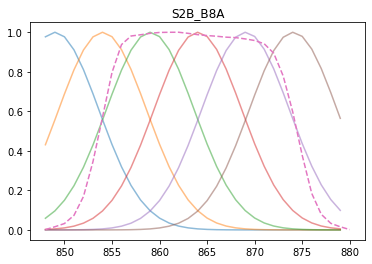

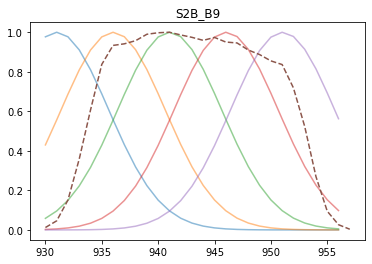

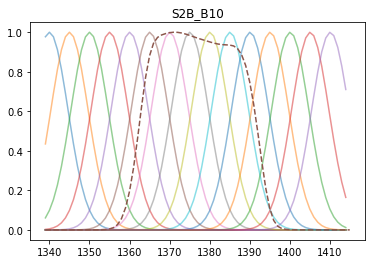

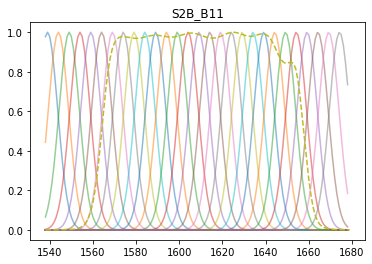

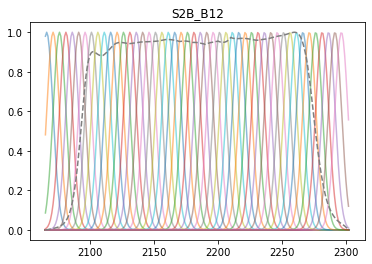

In [57]:
# get the sentinel-2b weights

HS_band_centers = nis_wavs
HS_FWHM = nis_fwhm
iter_bands = zip(s2b_bands, s2b_band_text)

S2B_weights_dict = {}
for s2_band, band_label in iter_bands:
#     target_bandpass = s2b_wavs
#     target_RSR = s2b_df[s2_band].values
    
    target_RSR = s2b_df[s2_band].values
    idx = np.where(target_RSR > 0)
    target_RSR = target_RSR[idx]
    target_bandpass = s2b_wavs[idx]

    values_lower = np.where(HS_band_centers>np.min(target_bandpass))
    values_upper = np.where(HS_band_centers<np.max(target_bandpass))
    values = np.intersect1d(values_lower,values_upper) # valid band centers relative to target band pass

    elements = values.shape[0]


    target_resample_range = np.arange(np.min(target_bandpass),np.max(target_bandpass),1)
    target_resample = np.interp(target_resample_range, target_bandpass, target_RSR)

    weights = np.zeros_like(values,dtype=np.float32)

    for i in range(elements):

        NEON_guassian_wave_params = np.array([[1,HS_band_centers[values[i]]-target_bandpass[0]-(HS_band_centers[values[0]]-target_bandpass[0])+2,sigma*HS_FWHM[values[i]]]],dtype = np.float32)
        NEON_gaussian_wave = get_fit_wave(NEON_guassian_wave_params, target_bandpass[-1]-target_bandpass[0]+1, 1)
        weights[i] = np.convolve(target_resample,NEON_gaussian_wave,mode='valid')
        plt.plot(target_resample_range,NEON_gaussian_wave, alpha=0.5)

    plt.plot(target_bandpass, target_RSR, '--')
    plt.title(band_label)
    plt.show()
    
    S2B_weights_dict[band_label] = (weights.tolist(), values.tolist())

Do the same for planet RSRs

In [58]:
planet_rsr = glob('./spectral_response/Planet*.csv')
planet_rsr

['./spectral_response\\PlanetScopeSD_RSR_SatID_10xx.csv',
 './spectral_response\\PlanetScope_RSR_SatID_0c_0d.csv',
 './spectral_response\\PlanetScope_RSR_SatID_0e.csv',
 './spectral_response\\PlanetScope_RSR_SatID_10_xx.csv',
 './spectral_response\\PlanetScope_RSR_SatID_3K_3R_3S.csv']

In [59]:
planet_rsr[0].split('RSR_')

['./spectral_response\\PlanetScopeSD_', 'SatID_10xx.csv']

In [60]:
for f in planet_rsr:
    print(f)
    print(pd.read_csv(f).columns)

./spectral_response\PlanetScopeSD_RSR_SatID_10xx.csv
Index(['Wavelength (nm)', ' Blue response', ' Green response', ' Red response',
       ' NIR response'],
      dtype='object')
./spectral_response\PlanetScope_RSR_SatID_0c_0d.csv
Index(['Wavelength [µm]', 'Blue', 'Green', 'Red ', 'NIR'], dtype='object')
./spectral_response\PlanetScope_RSR_SatID_0e.csv
Index(['WL [µm]', 'Blue', 'Green', 'Red ', 'NIR'], dtype='object')
./spectral_response\PlanetScope_RSR_SatID_10_xx.csv
Index(['Wavelength (nm)', ' Blue', ' Green', ' Red', ' NIR'], dtype='object')
./spectral_response\PlanetScope_RSR_SatID_3K_3R_3S.csv
Index(['Wavelength (nm)', ' Blue response', ' Green response', ' Red response',
       ' NIR response'],
      dtype='object')


Blue_SatID_10xx [460 470 480 490 500 510]


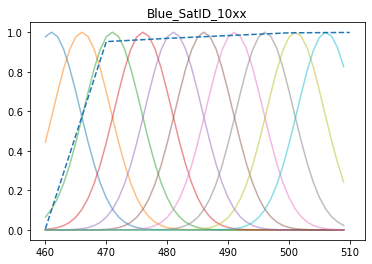

Green_SatID_10xx [550 560 570 580]


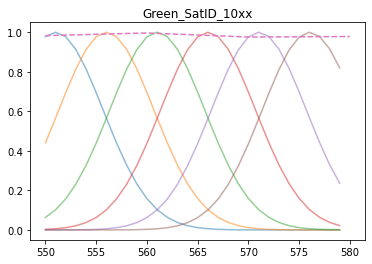

Red_SatID_10xx [650 660 670 680]


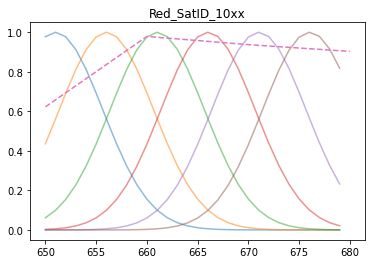

NIR_SatID_10xx [850 860 870 880 890]


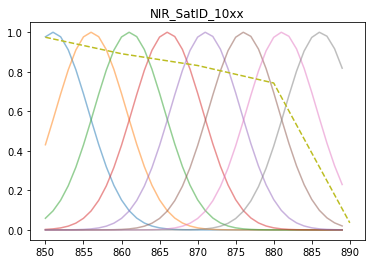

Blue_SatID_0c_0d [410. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530. 540. 550. 560.
 570. 660. 670. 680. 690.]


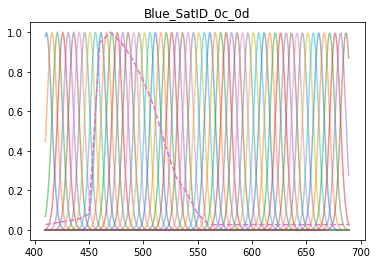

Green_SatID_0c_0d [450. 460. 470. 480. 490. 500. 510. 520. 530. 540. 550. 560. 570. 580.
 590. 600. 610. 620. 630. 640. 650. 660. 670. 680. 690.]


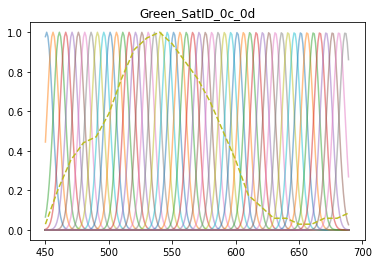

Red_SatID_0c_0d [460. 470. 480. 490. 500. 510. 520. 530. 540. 550. 560. 570. 580. 590.
 600. 610. 620. 630. 640. 650. 660. 670. 680. 690. 700.]


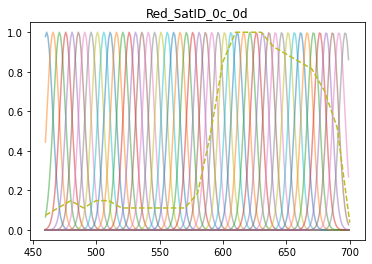

NIR_SatID_0c_0d [630. 690. 770. 780. 790. 800. 810. 820. 830. 840. 850. 860. 870. 880.]


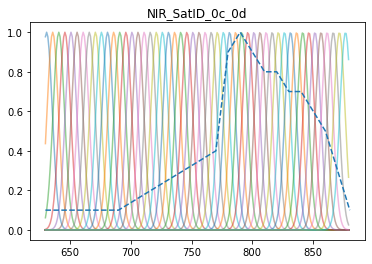

Blue_SatID_0e [400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530.
 540. 550. 560. 570. 580. 590. 600. 610. 620. 630. 640. 650. 660. 670.
 680. 690. 700. 810. 820. 830. 840. 850. 860. 870. 880. 890. 900. 910.
 920. 930. 940. 950. 960. 970.]


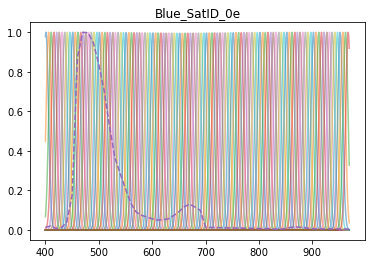

Green_SatID_0e [400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530.
 540. 550. 560. 570. 580. 590. 600. 610. 620. 630. 640. 650. 660. 670.
 680. 690. 700. 810. 820. 840. 850. 860. 870. 880. 890. 900. 910. 920.
 930. 940. 950. 960.]


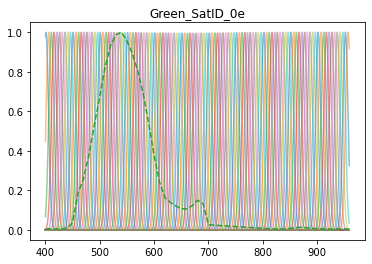

Red_SatID_0e [400. 410. 450. 460. 470. 480. 490. 500. 510. 520. 530. 540. 550. 560.
 570. 580. 590. 600. 610. 620. 630. 640. 650. 660. 670. 680. 690. 700.
 710. 810. 820. 830. 840. 850. 860. 870. 880. 890. 900. 910. 920. 930.
 940. 950. 960. 970.]


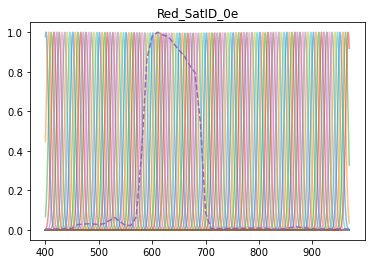

NIR_SatID_0e [480. 580. 590. 620. 630. 670. 680. 690. 700. 720. 750. 760. 770. 780.
 790. 800. 810. 820. 830. 840. 850. 860. 870. 880. 890.]


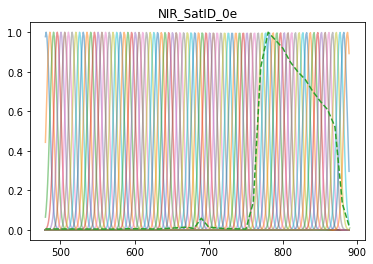

Blue_SatID_10_xx [460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514 515 516 517 518 519]


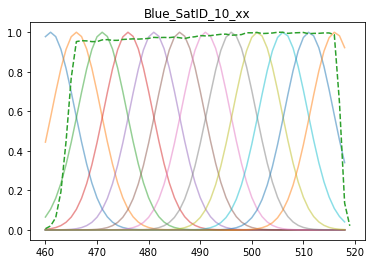

Green_SatID_10_xx [531 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577
 578 579 580 581 582 583 584 585 586 587 588]


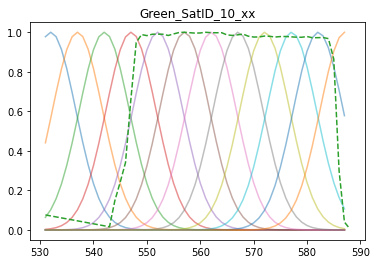

Red_SatID_10_xx [646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663
 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681
 682 683 684 685 686]


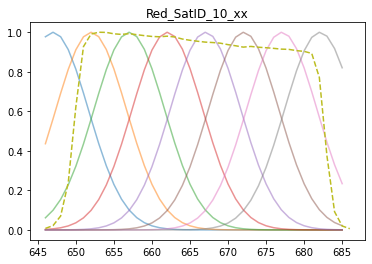

NIR_SatID_10_xx [842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859
 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877
 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892]


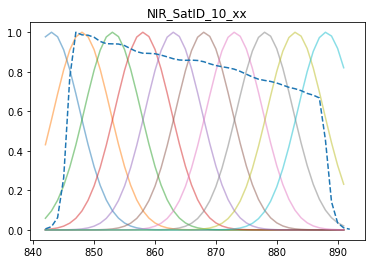

Blue_SatID_3K_3R_3S [460 470 480 490 500 510]


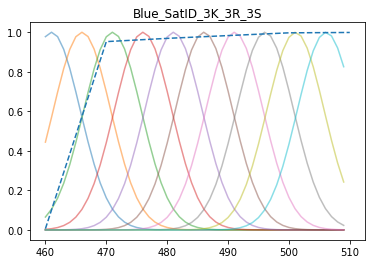

Green_SatID_3K_3R_3S [550 560 570 580]


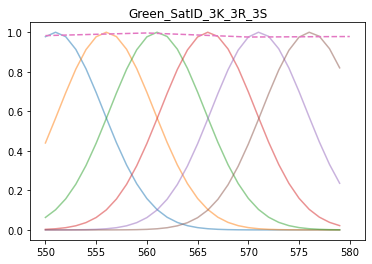

Red_SatID_3K_3R_3S [650 660 670 680]


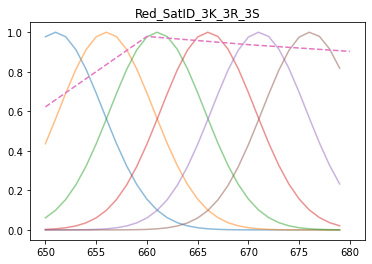

NIR_SatID_3K_3R_3S [850 860 870 880 890]


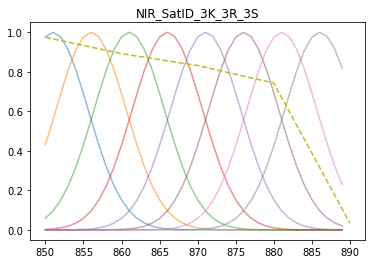

In [61]:
pl_dicts = []
for f in planet_rsr:
    df = pd.read_csv(f)
    
    cols = df.columns
    
    if 'nm' in cols[0]:
        pl_wavs = df[cols[0]].values
    
    else: #in um
        pl_wavs = df[cols[0]].values * 1000
    
    pl_id = f.split('RSR_')[1].split('.')[0]
    pl_band_text = [f'Blue_{pl_id}', f'Green_{pl_id}', f'Red_{pl_id}', f'NIR_{pl_id}']
    
    HS_band_centers = nis_wavs
    HS_FWHM = nis_fwhm
    iter_bands = zip(df.columns[1:], pl_band_text)

    pl_weights_dict = {}
    for pl_band, band_label in iter_bands:
        #target_bandpass = pl_wavs
        #target_RSR = df[pl_band].values
        
        target_RSR = df[pl_band].values
        idx = np.where(target_RSR > 0.003)
        target_RSR = target_RSR[idx]
        target_bandpass = pl_wavs[idx]
        
        print(band_label,target_bandpass)

        values_lower = np.where(HS_band_centers>np.min(target_bandpass))
        values_upper = np.where(HS_band_centers<np.max(target_bandpass))
        values = np.intersect1d(values_lower,values_upper) # valid band centers relative to target band pass

        elements = values.shape[0]


        target_resample_range = np.arange(np.min(target_bandpass),np.max(target_bandpass),1)
        target_resample = np.interp(target_resample_range, target_bandpass, target_RSR)

        weights = np.zeros_like(values,dtype=np.float32)

        for i in range(elements):

            NEON_guassian_wave_params = np.array([[1,HS_band_centers[values[i]]-target_bandpass[0]-(HS_band_centers[values[0]]-target_bandpass[0])+2,sigma*HS_FWHM[values[i]]]],dtype = np.float32)
            NEON_gaussian_wave = get_fit_wave(NEON_guassian_wave_params, target_bandpass[-1]-target_bandpass[0]+1, 1)
            weights[i] = np.convolve(target_resample,NEON_gaussian_wave,mode='valid')
            plt.plot(target_resample_range,NEON_gaussian_wave, alpha=0.5)

        plt.plot(target_bandpass, target_RSR, '--')
        plt.title(band_label)
        plt.show()

        pl_weights_dict[band_label] = (weights.tolist(), values.tolist())
    
#         if 'Red' in band_label:
#             break
#     break
    pl_dicts.append(pl_weights_dict)

In [62]:
target_RSR, target_bandpass, weights

(array([0.9745837 , 0.8913234 , 0.83172656, 0.74320771, 0.03593339]),
 array([850, 860, 870, 880, 890], dtype=int64),
 array([ 2.6787279,  5.729648 ,  8.114232 ,  9.233165 ,  9.758262 ,
        10.135178 , 10.178715 ,  8.370559 ], dtype=float32))

write out each sensor's weights and band indexes to a json file

In [63]:
for i,f in enumerate(planet_rsr):
    pl_id = f.split('RSR_')[1].split('.')[0]
    pl_file = 'NIS_weights_PlanetScope_' + pl_id + '.json'
    json_fi = os.path.join('./spectral_response_cutoff/', pl_file)
    
    print(json_fi)
    
    with open(json_fi, 'w') as fb:
        json.dump(pl_dicts[i], fb)

./spectral_response_cutoff/NIS_weights_PlanetScope_SatID_10xx.json
./spectral_response_cutoff/NIS_weights_PlanetScope_SatID_0c_0d.json
./spectral_response_cutoff/NIS_weights_PlanetScope_SatID_0e.json
./spectral_response_cutoff/NIS_weights_PlanetScope_SatID_10_xx.json
./spectral_response_cutoff/NIS_weights_PlanetScope_SatID_3K_3R_3S.json


In [64]:
l8_json_file = 'NIS_weights_L8.json'
json_fi = os.path.join('./test_sigma_SR2/', l8_json_file)
with open(json_fi, 'w') as fb:
    json.dump(L8_weights_dict, fb)

In [65]:
l7_json_file = 'NIS_weights_L7.json'
json_fi = os.path.join('./test_sigma_SR2/', l7_json_file)
with open(json_fi, 'w') as fb:
    json.dump(L7_weights_dict, fb)

In [66]:
S2A_json_file = 'NIS_weights_S2A.json'
json_fi = os.path.join('./test_sigma_SR2/', S2A_json_file)
with open(json_fi, 'w') as fb:
    json.dump(S2A_weights_dict, fb)
    
    
S2B_json_file = 'NIS_weights_S2B.json'
json_fi = os.path.join('./test_sigma_SR2/', S2B_json_file)
with open(json_fi, 'w') as fb:
    json.dump(S2B_weights_dict, fb)

compare weights from OLI to 1.201 sigma

In [67]:
l8_og = os.path.join('./spectral_response_cutoff/NIS_weights_L8.json')
l8_up = os.path.join('./test_sigma_SR/NIS_weights_L8.json')
l8_up2 = os.path.join('./test_sigma_SR2/NIS_weights_L8.json')

with open(l8_og) as fi:
    l8_og_dict = json.load(fi)
    
with open(l8_up) as fi:
    l8_up_dict = json.load(fi)
    
with open(l8_up2) as fi:
    l8_up_dict2 = json.load(fi)

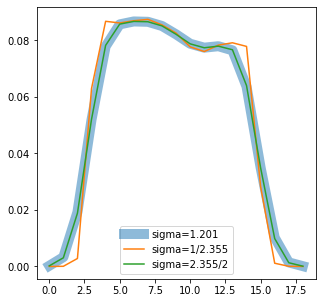

In [72]:
plt.figure(figsize=(5,5))
plt.plot(np.array(l8_og_dict['L8_Blue'][0])/sum(l8_og_dict['L8_Blue'][0]), linewidth=10, alpha=0.5, label='sigma=1.201')
plt.plot(np.array(l8_up_dict['L8_Blue'][0])/sum(l8_up_dict['L8_Blue'][0]), label='sigma=1/2.355')
plt.plot(np.array(l8_up_dict2['L8_Blue'][0])/sum(l8_up_dict2['L8_Blue'][0]), label='sigma=2.355/2')
plt.legend()
plt.show()

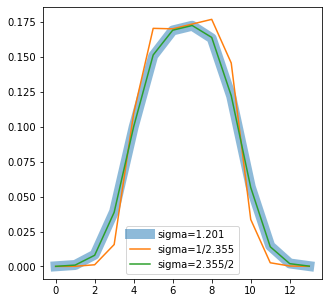

In [73]:
plt.figure(figsize=(5,5))
plt.plot(np.array(l8_og_dict['L8_NIR'][0])/sum(l8_og_dict['L8_NIR'][0]), linewidth=10, alpha=0.5, label='sigma=1.201')
plt.plot(np.array(l8_up_dict['L8_NIR'][0])/sum(l8_up_dict['L8_NIR'][0]), label='sigma=1/2.355')
plt.plot(np.array(l8_up_dict2['L8_NIR'][0])/sum(l8_up_dict2['L8_NIR'][0]), label='sigma=2.355/2')
plt.legend()
plt.show()